## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.models import ViTFeatureExtractor
from torchlake.semantic_segmentation.models.setr import SETR
from torchlake.common.controller.recorder import TrainRecorder
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/setr")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 224

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)

In [6]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)


In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

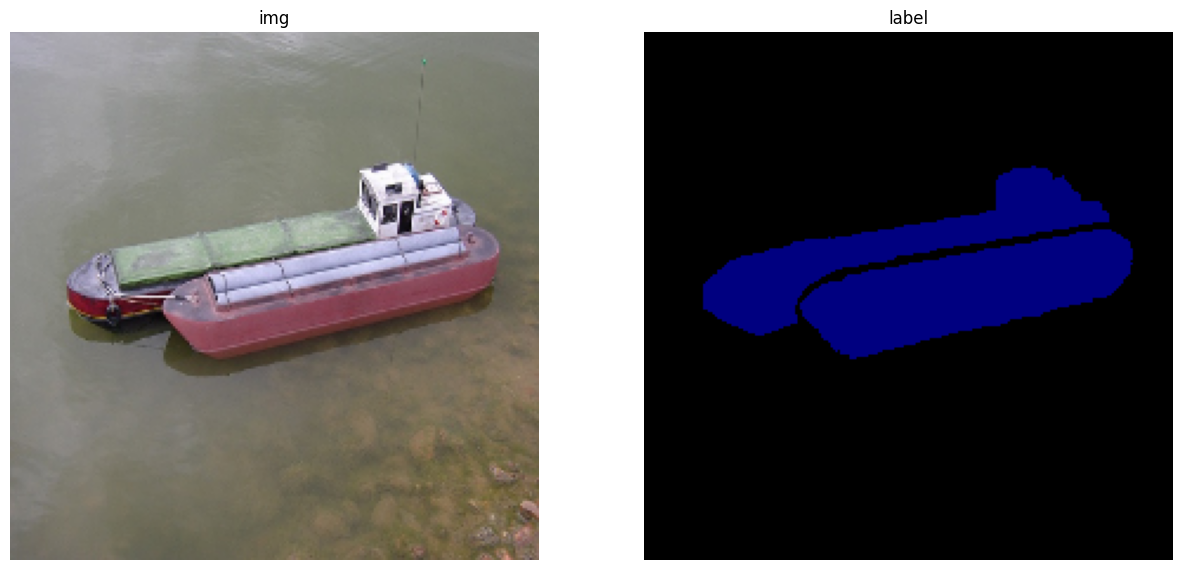

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [51]:
DECODER = "MLA"

In [52]:
backbone = ViTFeatureExtractor("b16", trainable=False)

In [53]:
model = SETR(backbone, output_size=20 + 1, decoder=DECODER).to(DEVICE)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                      Param #
SETR                                                                        --
├─ViTFeatureExtractor: 1-1                                                  --
│    └─VisionTransformer: 2-1                                               768
│    │    └─Conv2d: 3-1                                                     (590,592)
│    │    └─Encoder: 3-2                                                    (85,207,296)
│    └─ImageNetNormalization: 2-2                                           --
├─MLADecoder: 1-2                                                           --
│    └─ModuleList: 2-3                                                      --
│    │    └─Conv2d: 3-3                                                     196,864
│    │    └─Conv2d: 3-4                                                     196,864
│    │    └─Conv2d: 3-5                                                     196,864
│    │    └─Co

# train

In [14]:
EPOCHES = 10

In [15]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [16]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [18]:
scaler = torch.cuda.amp.GradScaler()

In [19]:
recorder = TrainRecorder(total_epoch=EPOCHES)
recorder.increment_data_size(len(train_dataset))

In [20]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 182/182 [00:27<00:00,  6.68it/s]


Epoch 1 : 0.1239870609469403 (0%)


100%|██████████| 182/182 [00:25<00:00,  7.28it/s]


Epoch 2 : 0.02440851719629875 (-80%)


100%|██████████| 182/182 [00:25<00:00,  7.18it/s]


Epoch 3 : 0.022004609260614743 (-10%)


100%|██████████| 182/182 [00:29<00:00,  6.13it/s]


Epoch 4 : 0.02198282110294116 (0%)


100%|██████████| 182/182 [00:26<00:00,  6.91it/s]


Epoch 5 : 0.021431636751987167 (-3%)


100%|██████████| 182/182 [00:26<00:00,  6.75it/s]


Epoch 6 : 0.021230816958779687 (-1%)


100%|██████████| 182/182 [00:26<00:00,  6.93it/s]


Epoch 7 : 0.014791621103079673 (-30%)


100%|██████████| 182/182 [00:26<00:00,  6.89it/s]


Epoch 8 : 0.013284986394297982 (-10%)


100%|██████████| 182/182 [00:25<00:00,  7.06it/s]


Epoch 9 : 0.012720602133860925 (-4%)


100%|██████████| 182/182 [00:25<00:00,  7.16it/s]

Epoch 10 : 0.012461154627362114 (-2%)


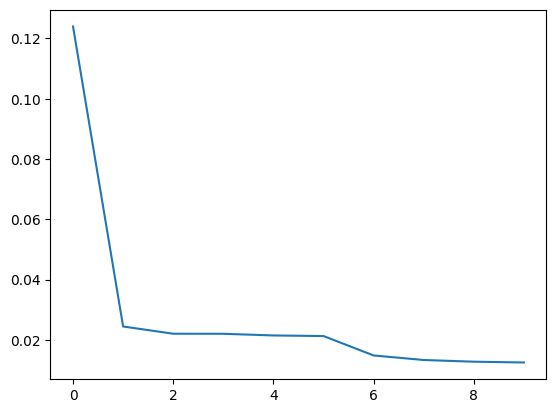

In [21]:
plt.plot(training_loss)

In [22]:
from torchlake.common.controller.weight_manager import WeightManager

In [54]:
manager = WeightManager(artifacts_path.joinpath("setr.{decoder}.pth").as_posix())

In [55]:
model_path = manager.get_filename(decoder=DECODER)

In [56]:
model_path

WindowsPath('../../artifacts/setr/setr.MLA.pth')

In [26]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\setr\setr.MLA.pth, model size is 349.12MiB


In [40]:
get_file_size(artifacts_path.joinpath("setr.pup.pth"))

'338.8MiB'

# inference

In [57]:
manager.load_weight(model_path, model)

In [28]:
# for inference, be cautious if you have not saved trained weights
if hasattr(model, "aux"):
    del model.aux

In [29]:
# model_path = artifacts_path.joinpath('pspnet.inference.pth')

In [30]:
# torch.save(model.state_dict(), model_path)

In [31]:
# get_file_size(model_path)

In [32]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [33]:
test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [34]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### dice coef

In [35]:
from torchmetrics.classification import jaccard

In [58]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 40/40 [00:05<00:00,  6.73it/s]


In [59]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.75 
bicycle        : 0.4  
bird           : 0.84 
boat           : 0.73 
bottle         : 0.71 
bus            : 0.84 
car            : 0.77 
cat            : 0.87 
chair          : 0.38 
cow            : 0.73 
diningtable    : 0.75 
dog            : 0.75 
horse          : 0.67 
motorbike      : 0.69 
person         : 0.74 
pottedplant    : 0.38 
sheep          : 0.76 
sofa           : 0.54 
train          : 0.83 
tvmonitor      : 0.7  
----------------------
total          : 0.69 


### for image in dataset

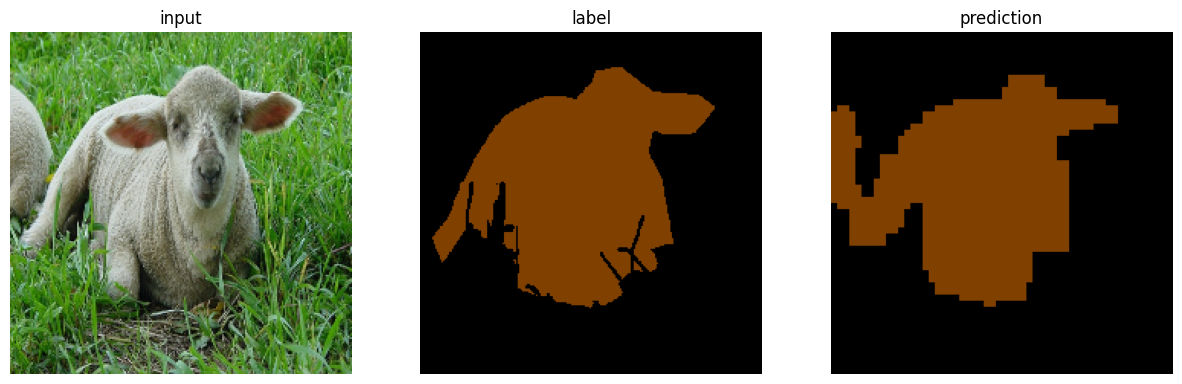

In [60]:
interest_pic = 11

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

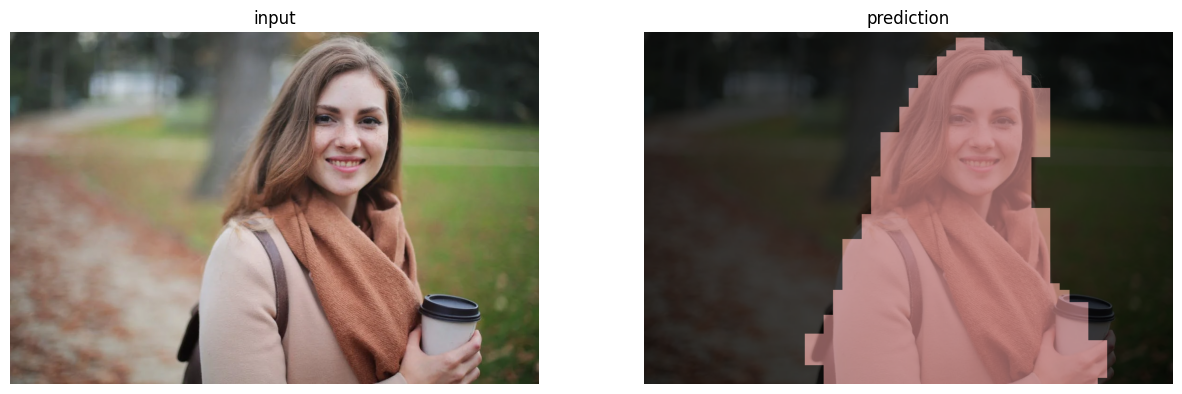

In [39]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )